# Find Patients with DM2, Multiple Visits, and a Change in DM2 Diagnoses Over Time

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [2]:
diagnoses = pd.read_csv('DIAGNOSES_ICD.csv')

Any of the following ICD9 Codes would indicate that a patient has DM2

In [3]:
DM2codes = ['25000','25002','25010','25012','25020','25022','25030','25032',
         '25040','25042','25050','25052','25060','25062','25070','25072',
         '25080','25082''25090','25092','V5867']

In [4]:
DM2patients = []
for index,row in diagnoses.iterrows():
    if(row['ICD9_CODE'] in DM2codes):
        DM2patients.append(row['SUBJECT_ID'])
DM2patients = list(set(DM2patients))

The following length represents how many time all the above DM2codes are diagnosed - 9785

In [5]:
print(len(DM2patients))

9785


In [6]:
admissions = pd.read_csv('ADMISSIONS.csv')

In [7]:
allPatients = []
multipleVisits = []
for index,row in admissions.iterrows():
    if(row['SUBJECT_ID'] in allPatients):
        multipleVisits.append(row['SUBJECT_ID'])
    else:
        allPatients.append(row['SUBJECT_ID'])
multipleVisits = list(set(multipleVisits))

The following list length represents how many patients have had multiple visits to the ICU - 7537

In [8]:
print(len(multipleVisits))

7537


In [9]:
DM2multiVisits = []
for patient in multipleVisits:
    if patient in DM2patients:
        DM2multiVisits.append(patient)

The following list length represents how many of te multiple visit patients also have been diagnosed with DM2 - 2634

In [10]:
print(len(DM2multiVisits))

2634


---

The purpose of the following section is to show the distribution of multiple visit patients

In [11]:
Num_Visits_Lib = {}
for index, row in admissions.iterrows():
    if(row['SUBJECT_ID'] in DM2multiVisits):
        if(row['SUBJECT_ID'] in Num_Visits_Lib):
            Num_Visits_Lib[row['SUBJECT_ID']] += 1;
        else:
            Num_Visits_Lib[row['SUBJECT_ID']] = 1; 
    

In [12]:
with open('num_visits_lib.txt', 'w') as f:
    json.dump(Num_Visits_Lib, f)

In [13]:
df = pd.DataFrame(columns=['patient','times_visited'])
for patient,visits in Num_Visits_Lib.items():
    new_row = pd.DataFrame([[patient,visits]],columns=['patient','times_visited'])
    df = df.append(new_row)    

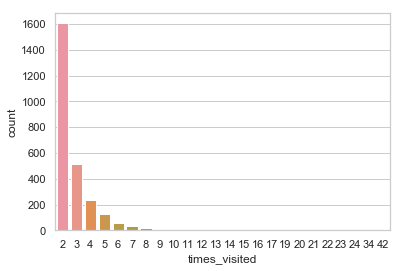

In [14]:
sns.set(style="whitegrid")
ax = sns.countplot(x="times_visited", data=df)

-----
The following code find all patients who meet the above criteria (DM2 and  multiple visits) and places them in a dataframe named masterDF

In [15]:
Hadm_Lib = {}
for index,row in admissions.iterrows():
    if(row['SUBJECT_ID'] in DM2multiVisits):
        Hadm_Lib.setdefault(row['SUBJECT_ID'], []).append(row['HADM_ID'])

In [17]:
all_hadm = []
for patient,hadm in Hadm_Lib.items():
    for x in hadm:
        all_hadm.append(x)  

In [18]:
All_Hadm_Lib = {}
for index,row in diagnoses.iterrows():
    if(row['HADM_ID'] in all_hadm):
        All_Hadm_Lib.setdefault(row['HADM_ID'], []).append(row['ICD9_CODE'])

In [16]:
def common_member(a, b): 
    a_set = set(a) 
    b_set = set(b) 
    if (a_set & b_set): 
        return True 
    else: 
        return False

In [19]:
masterDF = pd.DataFrame(columns=['hadm_id','diabeties code'])
for hadm,codes in All_Hadm_Lib.items():
    code_list = []
    for code in codes:
        code_list.append(code)
    new_row = pd.DataFrame([[hadm,(common_member(code_list,DM2codes))]],columns=['hadm_id','diabeties code'])
    masterDF = masterDF.append(new_row)       

Blow is an example of the masterDF dataframe

In [20]:
print(masterDF.head(5))

  hadm_id diabeties code
0  140784           True
0  164853           True
0  113323           True
0  198214           True
0  192180          False


----
The purpose of the following section is to add time of visit to the masterDF dataframe.

In [23]:
masterDF['SUBJECT_ID'] = 0
masterDF = masterDF.reset_index(drop=True)

In [24]:
for patient,hadm in Hadm_Lib.items():
    for index,row in masterDF.iterrows():
        if row['hadm_id'] in hadm:
            masterDF.at[index, 'SUBJECT_ID'] = patient

In [25]:
timeDF = pd.DataFrame(columns=['hadm_id','time'])

for index,row in admissions.iterrows():
    if(row['HADM_ID'] in all_hadm):
        new_row = pd.DataFrame([[row['HADM_ID'],row['ADMITTIME']]],columns=['hadm_id','time'])
        timeDF = timeDF.append(new_row) 

In [26]:
print(timeDF.head(5))

  hadm_id                 time
0  174486  2197-12-06 07:13:00
0  145674  2198-08-02 04:49:00
0  122609  2198-11-01 22:36:00
0  101651  2199-10-20 12:05:00
0  117876  2199-12-21 22:37:00


In [27]:
masterDF = pd.merge(left=masterDF,right=timeDF, left_on='hadm_id', right_on='hadm_id')

In [28]:
#print(masterDF)

---
THe remaining section does two things:
1. Finds only patients who have had a change in their DM2 status over multiple visits
2. Prepare the dataframe for the scatter plot graph (adding point color and the visit number for each patients visit

In [29]:
POI = []
for index,row in masterDF.iterrows():
    if(row['diabeties code'] == False):
        POI.append(row['SUBJECT_ID'])
POI = list(set(POI))



In [30]:
masterDF['time']=pd.to_datetime(masterDF['time'])
masterDF = masterDF.sort_values(by=['time'])

In [31]:
def pointColor (row):
    if row['diabeties code'] == True:
        return 'red'
    if row['diabeties code'] == False:
        return 'green'
    return 'error'

In [32]:
masterDF['DiagnosesColor'] = masterDF.apply (lambda row: pointColor (row),axis=1)

In [34]:
masterDF = pd.read_csv('masterPatient.csv')
#masterDF = masterDF.drop(['Unnamed: 0'],axis=1)
masterDF = masterDF.set_index('hadm_id')
masterDF['visit_num'] = 0

In [35]:
for patient in POI:
    df = masterDF.loc[masterDF['SUBJECT_ID'] == patient]
    df['hadm_id'] = df.index
    df = df.reset_index(drop=True)
    for index,row in df.iterrows():                
        masterDF.at[row['hadm_id'],'visit_num'] = (index+1)

c:\users\ian\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
for index,row in masterDF.iterrows():
    if(row['SUBJECT_ID'] not in POI):
        masterDF = masterDF.drop(index)

In [37]:
''' TEST
for patient in POI:
    df = masterDF.loc[masterDF['SUBJECT_ID'] == patient]
    if(patient == 9319):
        print('yes')
print('no')
'''

" TEST\nfor patient in POI:\n    df = masterDF.loc[masterDF['SUBJECT_ID'] == patient]\n    if(patient == 9319):\n        print('yes')\nprint('no')\n"

In [38]:
#masterDF.to_csv(r'masterPatient.csv')